# 1. Import Module & Data

In [1]:
import pandas as pd
%matplotlib inline
from matplotlib import figure
import matplotlib.pyplot as plt
import math
import os
import time
import random
import gc
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

data_folder = '../data/'
os.makedirs(data_folder, exist_ok=True)
data_file_train = 'mitbih_train.csv'
data_file_test = 'mitbih_test.csv'

In [3]:
df_train = pd.read_csv(data_folder+data_file_train, header=None)
df_test = pd.read_csv(data_folder+data_file_test, header=None)

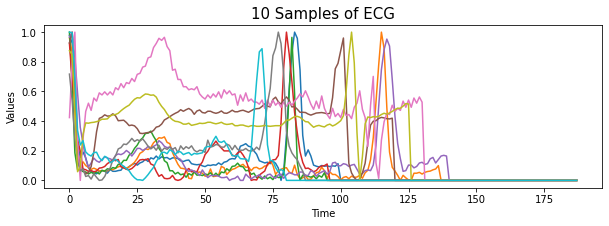

In [4]:
plt.figure(figsize=(10,3))
plt.plot(df_train.iloc[:10, :].T)
plt.title("10 Samples of ECG", fontsize=15)
plt.xlabel("Time", fontsize=10)
plt.ylabel("Values", fontsize=10)
plt.show()

In [5]:
from torch import nn
from torch.utils.data import Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch

import os
import statistics
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import matplotlib.pyplot as plt

SEED = 10
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

In [6]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = torch.Tensor(data)
        self.used_cols = [x for x in range(data.shape[1]-1)] # X = except target column
        
        self.shape = self.__getshape__()
        self.size = self.__getsize__()

    def __getitem__(self, index):
        x = self.data[index, self.used_cols].unsqueeze(1).T
        return x

    def __len__(self):
        return len(self.data) 
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape) # row, col
    
    def __getsize__(self):
        return (self.__len__())

In [7]:
batch_size = 64
num_workers = 4
pin_memory = True
num_class = 5
device = 'cuda'
num_epoch = 200
lr = 1e-4

In [8]:
print(len(df_train), len(df_test))

87554 21892


In [9]:
from sklearn.model_selection import train_test_split

train_dataset = MyDataset(df_train.values)

x_valid, x_test, y_valid, y_test = train_test_split(df_test.iloc[:,:-1],df_test.iloc[:,-1], test_size=0.5, shuffle=True, stratify=df_test.iloc[:,-1], random_state=SEED)
df_valid = pd.DataFrame(x_valid)
df_valid.insert(len(df_valid.columns), "target", pd.Series(y_valid))

df_test = pd.DataFrame(x_test)
df_test.insert(len(df_test.columns), "target", pd.Series(y_test))

valid_dataset = MyDataset(df_valid.values)
test_dataset = MyDataset(df_test.values)

In [10]:
### train / valid / test data length ###
print(len(df_train), len(df_valid), len(df_test))

87554 10946 10946


In [11]:
### train label counts ###
df_train.iloc[:, -1].value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

In [12]:
### valid label counts ###
df_valid.iloc[:, -1].value_counts()

0.0    9059
4.0     804
2.0     724
1.0     278
3.0      81
Name: target, dtype: int64

In [13]:
### test label counts ###
df_test.iloc[:, -1].value_counts()

0.0    9059
4.0     804
2.0     724
1.0     278
3.0      81
Name: target, dtype: int64

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=True) 
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

# 2. CNN Model (similar architecture w DynamicRouting CapsNet)

In [15]:
result_folder = '../check/cnn/reconstruction/'
os.makedirs(result_folder, exist_ok=True)

attack_result_folder = '../check/cnn/reconstruction_attack/'
os.makedirs(attack_result_folder, exist_ok=True)

In [16]:
class CNN(nn.Module):
    def __init__(self, in_features, out_features, pool_size, hidden_dim, capsule_num):
        super().__init__()
        self.output = out_features
        self.pool_size = pool_size
        
        self.hidden_dim = hidden_dim
        self.capsule_num = capsule_num
        
        self.conv1 = nn.Conv2d(in_features, self.hidden_dim, kernel_size=(1, 9), stride=1)
        self.pool1 = nn.MaxPool2d((1, self.pool_size),1)
        
        self.conv2 = nn.Conv2d(self.hidden_dim, self.hidden_dim, kernel_size=(1, 9), stride=(1,2))
        self.pool2 = nn.MaxPool2d((1, self.pool_size),1)
        
        self.conv3 = nn.Conv2d(self.hidden_dim, 5*16, kernel_size=(1,1), stride=1)
        self.pool3 = nn.AdaptiveMaxPool2d(1)
       
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(5*16, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.out = nn.Linear(1024, out_features)

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x.unsqueeze(2))))
        x = F.relu(self.pool2(self.conv2(x)))
        x = F.relu(self.pool3(self.conv3(x)))
        
        x = self.flatten(x).unsqueeze(1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = (self.out(x))
        
        return x

In [17]:
model = CNN(in_features= 1,
            out_features=len(df_train.columns)-1, #classifcation = 5
            pool_size=2, hidden_dim = 256, capsule_num=8).to(device) 

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min')
criterion = nn.MSELoss()

In [18]:
model

CNN(
  (conv1): Conv2d(1, 256, kernel_size=(1, 9), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(1, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(256, 256, kernel_size=(1, 9), stride=(1, 2))
  (pool2): MaxPool2d(kernel_size=(1, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 80, kernel_size=(1, 1), stride=(1, 1))
  (pool3): AdaptiveMaxPool2d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=80, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1024, bias=True)
  (out): Linear(in_features=1024, out_features=187, bias=True)
)

# 3. Model Training & Evaluation #

In [19]:
train_loss_list = []
valid_loss_list = []
    
for epoch in range(0, num_epoch+1):
    model = model.train()

    train_loss = []
    for (x) in tqdm(train_loader, leave=False):
        x = x.to(device)

        optimizer.zero_grad()
        outputs = model(x)

        loss = criterion(outputs, x)
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    
    model = model.eval()
    predictions = []
    answers = []
    valid_loss = []
    with torch.no_grad():
        for (x) in tqdm(valid_loader, leave=False):
            x = x.to(device)
            
            answers.extend(x.squeeze().detach().cpu().numpy())

            outputs = model(x)
            loss = criterion(outputs, x)
        
            predictions.extend(outputs.squeeze().detach().cpu().numpy())
            valid_loss.append(loss.item())    

    valid_loss = np.mean(valid_loss)
    
    print("epoch: {}/{} | trn_loss: {:.4f} | val_loss: {:.4f}".format(
                epoch, num_epoch, train_loss, valid_loss
            ))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    """
    if epoch % 20 ==0 :
        torch.save({
            'epoch': epoch,
            'loss' :, valid_loss_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, f'./check/cnn/recon/cnn-swcapsule-recon-ecg-{epoch}.pt')
    """
    
    if (epoch==0) or (epoch>0 and (min(valid_loss_list[:-1])>valid_loss_list[-1])):
        torch.save({
            'epoch': epoch,
            'loss' : valid_loss_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'cnn-swcapsule-recon-ecg-best.pt')

epoch: 0/200 | trn_loss: 0.0184 | val_loss: 0.0141


 22%|██▏       | 307/1369 [00:02<00:05, 177.61it/s]Exception in thread Thread-12:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 282, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/local/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/local/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = 

KeyboardInterrupt: 

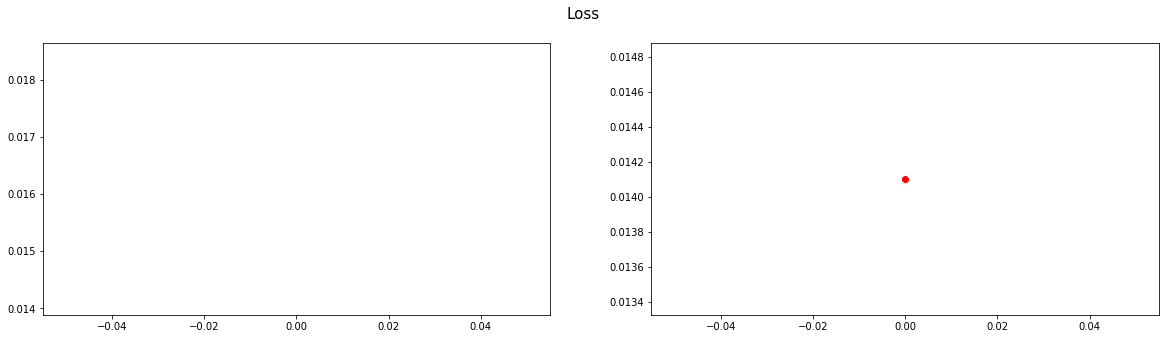

In [20]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax0 = ax[0]
ax0.plot(train_loss_list, c= 'blue')
ax0.plot(valid_loss_list, c='red')

ax1 = ax[1]
ax1.plot(valid_loss_list, c='red', marker='o')

fig.suptitle("Loss", fontsize=15)
plt.savefig(result_folder+'drcnn_loss.png')

In [21]:
pd.DataFrame([train_loss_list, valid_loss_list]).to_csv(result_folder + 'drcnn_loss.csv', index=0)

### Performance Evaluation

In [22]:
checkpoint = torch.load(result_folder+'cnn-swcapsule-recon-ecg-best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion = checkpoint['criterion']
print(checkpoint['epoch'], checkpoint['loss'])

0 0.014104184369708216


In [23]:
model = model.eval()
test_loss = []
answers = []
predictions = []
with torch.no_grad():
    for (x) in tqdm(test_loader, leave=False):
        x = x.to(device)
        answers.extend(x.squeeze().detach().cpu().numpy())

        outputs = model(x)
        loss = criterion(outputs, x) 
            
        predictions.extend(outputs.squeeze().detach().cpu().numpy())  
        test_loss.append(loss.item())
        
test_loss = np.mean(test_loss)
print(f'test loss: {test_loss}')

test loss: 0.014196084563208873


In [24]:
result_ans = pd.DataFrame(answers)
result_ans.to_csv(result_folder + 'recon_result.csv')

result_pred = pd.DataFrame(predictions)
result_pred.to_csv(result_folder + 'recon_pred.csv')

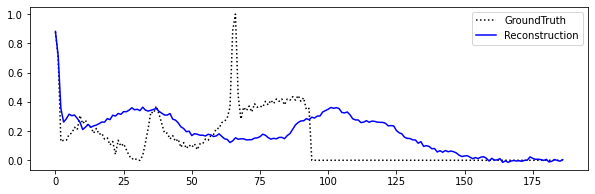

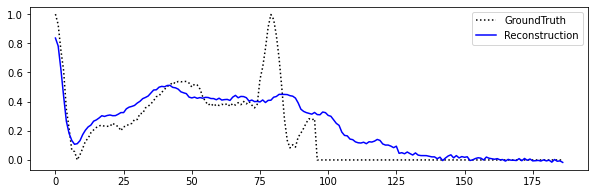

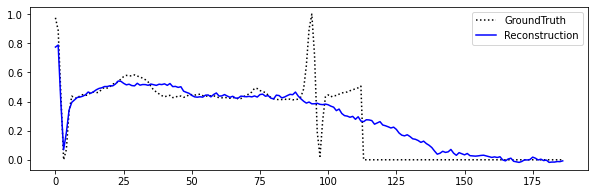

In [25]:
for i in range(3):
    plt.figure(figsize=(10,3))
    plt.plot(result_ans.iloc[i, :], c='black', ls=':', label = 'GroundTruth')
    plt.plot(result_pred.iloc[i, :], c='blue', label='Reconstruction')
    plt.legend()
    plt.savefig(result_folder + f'sample{i}_reconresult.png')

## Manual Attack

In [26]:
checkpoint = torch.load(result_folder+'cnn-swcapsule-recon-ecg-best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion = checkpoint['criterion']
print(checkpoint['epoch'], checkpoint['loss'])

0 0.014104184369708216


In [27]:
import copy
def offset(input_, offset=0.1, window=35, num_sample=1,
           random_noise=True, max_rand_noise=0.01, label_last_col=False, 
           multi_var=0):
    """
    input: pandas dataframe, its axis must be matched like (time, variable, ...)
    offset: constant value in the range of 0-1, which will be plus added.
    window: time window to be attacked.
    num_sample: number of records to be attacked.
    random_noise: adding brownian motion random noise.
    max_rand_noise: maximum random noise.
    label_last_col: whether last column is target label or not.
    multi_var: number of multivariate sensors to be attacked.
    return: normalized x, [attacked sample indices, time indices for start, and end]
    """
    x = copy.deepcopy(input_)
    assert window > 0 and window < x.shape[1], "Incorrect range of window"
    assert offset >= 0 and offset <= 1, "Incorrect range of offset value"
    if label_last_col==True:
        if len(x.shape)>2:
            label_col = x[:,-1,:]
            x = x[:,:-1,:]
        else:
            label_col = x.iloc[:,-1]
            x = x.iloc[:,:-1]

    idxs = range(num_sample)
    start_idx = np.random.randint(0, x.shape[1]-window, num_sample)
    indices = np.stack((idxs, start_idx, start_idx + window), axis=1)    
    
    if multi_var != 0: # multivariate (PeMS) [samples, time, sensor] =(10358, 168, 862)
        assert multi_var >= 0 and multi_var < x.shape[2], "Incorrect number of multivariate sensors to be attacked"
        sensor_idxs = np.random.randint(0, x.shape[2], multi_var)
        if random_noise == True:
            noise = np.random.normal(0, max_rand_noise, size=(len(idxs), window, multi_var))
            noise = np.around(noise,6)
        else:
            noise = np.zeros(shape=(len(idxs), window, multi_var))
        for p, sensor_idx in enumerate(sensor_idxs):
            for j, [i, start_idx, end_idx] in enumerate(indices):
                x[i, start_idx:end_idx, sensor_idx] += offset + noise[j,:,p]
#         x = x.clamp(min=0.0, max=1.0) # clipping 0 through 1
        if label_last_col==True:
            x = torch.cat((x, label_col.unsqueeze(1)), 1)
        return x, indices, sensor_idxs
    
    else: #univariate (ECG) [sample, time] =(21892, 188)
        if random_noise == True:
            noise = np.random.normal(0, max_rand_noise, size=(len(idxs), window))
            noise = np.around(noise,6)
        else:
            noise = np.zeros(shape=(len(idxs), window))
        for j, [i, start_idx, end_idx] in enumerate(indices):
            x.iloc[i,start_idx:end_idx] += offset + noise[j,:]
            
        x.clip(lower=0.0, upper=1.0, inplace=True) # clipping 0 through 1
        if label_last_col==True:
            x = pd.concat([x,label_col],axis=1)
    
        return x, indices
    
    
def drift(input_, scale=0.1, window=35, num_sample=1, type_='increasing', 
          random_noise=True, max_rand_noise=0.01, label_last_col=False,
          multi_var=0):
    """
    input: pandas dataframe, its axis must be matched like (time, variable, ...)
    scale: constant value in the range of 0-1, which will be plus increasingly added.
    window: time window to be attacked.
    num_sample: number of records to be attacked.
    type: options consists of 'increasing' and 'decreasing'
    random_noise: adding brownian motion random noise.
    max_rand_noise: maximum random noise.
    label_last_col: whether last column is target label or not.
    multi_var: number of multivariate sensors to be attacked.
    return: normalized x, [attacked sample indices, time indices for start, and end]
    """
    x = copy.deepcopy(input_)
    assert window > 0 and window < x.shape[1], "Incorrect range of window"
    assert scale >= 0 and scale <= 1, "Incorrect range of scale value"
    
    if label_last_col==True:
        if len(x.shape)>2:
            label_col = x[:,-1,:]
            x = x[:,:-1,:]
        else:
            label_col = x.iloc[:,-1]
            x = x.iloc[:,:-1]
    idxs = range(num_sample)
    start_idx = np.random.randint(0, x.shape[1]-window, num_sample)
    if len(x.shape)<3:
        start_idx = np.random.randint(0, x.shape[1]//2, num_sample)
    indices = np.stack((idxs, start_idx, start_idx + window), axis=1)

    if multi_var > 0: # multivariate (PeMS) [samples, time, sensor] =(10358, 168, 862)
        assert multi_var >= 0 and multi_var < x.shape[2], "Incorrect number of multivariate sensors to be attacked"
        sensor_idxs = np.random.randint(0, x.shape[2], multi_var)
        if random_noise == True:
            noise = np.random.normal(0, max_rand_noise, size=(len(idxs), window, multi_var))
            noise = np.around(noise,6)
        else:
            noise = np.zeros(shape=(len(idxs), window, multi_var))
        f = np.linspace(start=0, stop=scale, num=window) 
        if type_ =='decreasing':
            f = -f
        for p, sensor_idx in enumerate(sensor_idxs):
            for j, [i, start_idx, end_idx] in enumerate(indices):
                x[i, start_idx:end_idx, sensor_idx] += f + noise[j,:,p]
#         x = x.clamp(min=0.0, max=1.0) # clipping 0 through 1
        if label_last_col==True:
            x = torch.cat((x, label_col.unsqueeze(1)), 1)
        return x, indices, sensor_idxs
    
    else: #univariate (ECG) [sample, time] =(21892, 188)
        if random_noise == True:
            noise = np.random.normal(0, max_rand_noise, size=(len(idxs), window))
            noise = np.around(noise,6)
        else:
            noise = np.zeros(shape=(len(idxs), window))
        f = np.linspace(start=0, stop=scale, num=window) 
        if type_ =='decreasing':
            f = -f
        for j, [i, start_idx, end_idx] in enumerate(indices):
            x.iloc[i, start_idx:end_idx] += f + noise[j,:]
        x.clip(lower=0.0, upper=1.0, inplace=True) # clipping 0 through 1
        if label_last_col==True:
            x = pd.concat([x,label_col],axis=1)
        return x, indices
    

def lagging(input_, lag_time=15, num_sample=1, multi_var=0, type_='backward',
            random_noise=True, max_rand_noise=0.01, label_last_col=False):
    """
    input: pandas dataframe, its axis must be matched like (time, variable, ...).
    lag_time: integer which is lagging duration.
    num_sample: number of records to be attacked.
    random_noise: adding brownian motion random noise.
    max_rand_noise: maximum random noise.
    label_last_col: whether last column is target label or not.
    multi_var: number of multivariate sensors to be attacked.
    return: normalized x, [attacked sample indices, time indices for start]
    """
    x = copy.deepcopy(input_)
    assert lag_time >= 0, "Incorrect range of lag time"
#     assert type(lag_time) is int, "Incorrect data type of lag time"
    if label_last_col==True:
        if len(x.shape)>2: # multivariate
            label_col = x[:,-1,:]
            x = x[:,:-1,:]
        else: #univariate
            label_col = x.iloc[:,-1]
            x = x.iloc[:,:-1]
    
    idxs = range(num_sample)
    if type_=='backward':
        start_idx = np.random.randint(lag_time, x.shape[1]-2*lag_time, num_sample)
        if len(x.shape)<3:
            start_idx = np.random.randint(lag_time, x.shape[1]//2, num_sample)
    else: # 'forward'
        start_idx = np.random.randint(2*lag_time, x.shape[1]-lag_time, num_sample)
        if len(x.shape)<3:
            start_idx = np.random.randint(lag_time, x.shape[1]//2, num_sample)
    indices = np.stack((idxs, start_idx), axis=1)            
    if multi_var > 0: # multivariate (PeMS) [samples, time, sensor] =(10358, 168, 862)
        assert multi_var >= 0 and multi_var < x.shape[2], "Incorrect number of multivariate sensors to be attacked"
        sensor_idxs = np.random.randint(0, x.shape[2], multi_var)
        
        for _, [i, start_idx] in enumerate(indices):
            if type_=='backward':
                if random_noise == True:
                    noise = np.random.normal(0, max_rand_noise, size=(x[i,start_idx-lag_time:x.shape[1],0].shape[0], multi_var))
                    noise = np.around(noise,6)
                else:
                    noise = np.zeros(shape=(x[i,start_idx-lag_time:x.shape[1],0].shape[0], multi_var))
                for p, sensor_idx in enumerate(sensor_idxs): 
                    x[i,start_idx:x.shape[1],sensor_idx] = copy.deepcopy(x[i,start_idx-lag_time:x.shape[1]-lag_time,sensor_idx])
                    x[i,start_idx-lag_time:start_idx,sensor_idx] = copy.deepcopy(x[i,start_idx-lag_time,sensor_idx])
                    x[i,start_idx-lag_time:x.shape[1],sensor_idx] += noise[:,p]
            else: # 'forward'
                if random_noise == True:
                    noise = np.random.normal(0, max_rand_noise, size=(x[i,start_idx-lag_time:x.shape[1],0].shape[0], multi_var))
                    noise = np.around(noise,6)
                else:
                    noise = np.zeros(shape=(x[i,start_idx-lag_time:x.shape[1],0].shape[0], multi_var))
                for p, sensor_idx in enumerate(sensor_idxs): 
                    x[i,start_idx-lag_time:x.shape[1]-lag_time,sensor_idx] = x[i,start_idx:x.shape[1],sensor_idx]
                    x[i,x.shape[1]-lag_time:x.shape[1],sensor_idx] = x[i,x.shape[1]-lag_time,sensor_idx]
                    x[i,start_idx-lag_time:x.shape[1],sensor_idx] += noise[:,p]
#         x = x.clamp(min=0.0, max=1.0) # clipping 0 through 1
        if label_last_col==True:
            x = torch.cat((x, label_col.unsqueeze(1)), 1)
        return x, indices, sensor_idxs
    
    else: #univariate (ECG) [sample, time] =(21892, 188)
        for _, [i, start_idx] in enumerate(indices):
            if type_=='backward':
                if random_noise == True:
                    noise = np.random.normal(0, max_rand_noise, size=(x.iloc[i,start_idx-lag_time:x.shape[1]].shape[0]))
                    noise = np.around(noise,6)
                else:
                    noise = np.zeros(shape=(x.iloc[i,start_idx-lag_tim:x.shape[1]].shape[0]))
                x.iloc[i,start_idx-lag_time:x.shape[1]] = x.iloc[i,start_idx-lag_time:x.shape[1]].shift(periods=lag_time, fill_value=x.iloc[i,start_idx-lag_time])
                x.iloc[i,start_idx-lag_time:x.shape[1]] += noise
            else:
                if random_noise == True:
                    noise = np.random.normal(0, max_rand_noise, size=(x.iloc[i,start_idx:x.shape[1]].shape[0]))
                    noise = np.around(noise,6)
                else:
                    noise = np.zeros(shape=(x.iloc[i,start_idx:x.shape[1]].shape[0]))
                x.iloc[i,start_idx:x.shape[1]] = x.iloc[i,start_idx:x.shape[1]].shift(periods=-lag_time-1, fill_value=0)
                x.iloc[i,start_idx:x.shape[1]] += noise     
        x.clip(lower=0.0, upper=1.0, inplace=True) # clipping 0 through 1
        if label_last_col==True:
            x = pd.concat([x,label_col],axis=1)
        return x, indices

In [28]:
offsets, offset_idx = offset(df_test, offset=0.1, window=55, num_sample=df_test.shape[0], 
                             max_rand_noise=0.01, label_last_col=True)
increasing, increase_idx = drift(df_test, scale=0.2, window=55, num_sample=df_test.shape[0], type_='increasing',
                            max_rand_noise=0.01, label_last_col=True)
decreasing, decrease_idx = drift(df_test, scale=0.2, window=55, num_sample=df_test.shape[0], type_='decreasing',
                            max_rand_noise=0.01, label_last_col=True)
backward, backward_idx = lagging(df_test, lag_time=10, num_sample=df_test.shape[0], type_="backward", 
                            max_rand_noise=0.01, label_last_col=True)
forward, forward_idx   = lagging(df_test, lag_time=10, num_sample=df_test.shape[0], type_="forward", 
                            max_rand_noise=0.01, label_last_col=True)

offset_test_dataset = MyDataset(offsets.values)
offset_test_loader = torch.utils.data.DataLoader(offset_test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

increasing_test_dataset = MyDataset(increasing.values)
increasing_test_loader = torch.utils.data.DataLoader(increasing_test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

decreasing_test_dataset = MyDataset(decreasing.values)
decreasing_test_loader = torch.utils.data.DataLoader(decreasing_test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

backward_test_dataset = MyDataset(backward.values)
backward_test_loader = torch.utils.data.DataLoader(backward_test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

forward_test_dataset = MyDataset(forward.values)
forward_test_loader = torch.utils.data.DataLoader(forward_test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

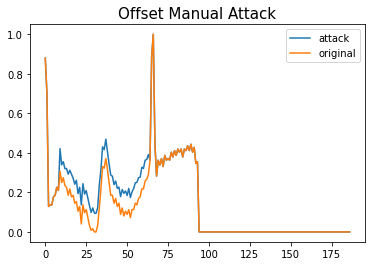

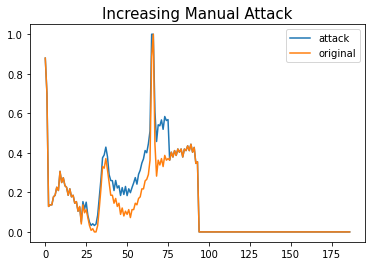

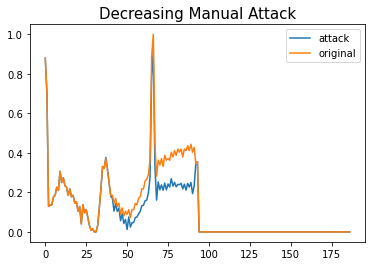

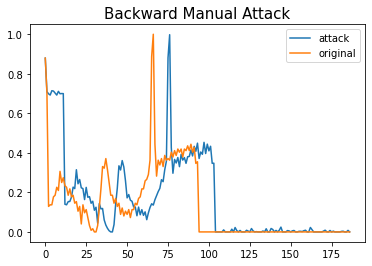

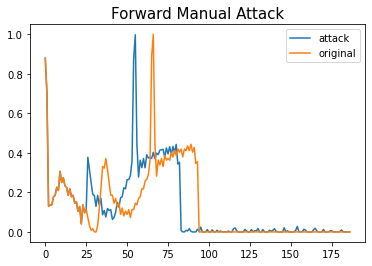

In [29]:
plt.plot(offsets.iloc[offset_idx[0,0],:-1], label='attack')
plt.plot(df_test.iloc[offset_idx[0,0],:-1], label='original')
plt.legend()
plt.title("Offset Manual Attack", fontsize=15)
plt.show()
plt.plot(increasing.iloc[increase_idx[0,0],:-1], label='attack')
plt.plot(df_test.iloc[increase_idx[0,0],:-1], label='original')
plt.legend()
plt.title("Increasing Manual Attack", fontsize=15)
plt.show()
plt.plot(decreasing.iloc[decrease_idx[0,0],:-1], label='attack')
plt.plot(df_test.iloc[decrease_idx[0,0],:-1], label='original')
plt.legend()
plt.title("Decreasing Manual Attack", fontsize=15)
plt.show()
plt.plot(backward.iloc[backward_idx[0,0],:-1], label='attack')
plt.plot(df_test.iloc[backward_idx[0,0],:-1], label='original')
plt.legend()
plt.title("Backward Manual Attack", fontsize=15)
plt.show()
plt.plot(forward.iloc[forward_idx[0,0],:-1], label='attack')
plt.plot(df_test.iloc[forward_idx[0,0],:-1], label='original')
plt.legend()
plt.title("Forward Manual Attack", fontsize=15)
plt.show()

In [30]:
def attack_inference(model, test_loader, attack):
    model = model.eval()
    test_loss = []
    predictions = []
    answers = []
    with torch.no_grad():
        for (x) in tqdm(test_loader, leave=False):
            x = x.to(device)

            answers.extend(x.squeeze().detach().cpu().numpy())

            outputs = model(x).squeeze()
            loss = criterion(outputs, x) 

            predictions.extend(outputs.squeeze().detach().cpu().numpy())  

            test_loss.append(loss.item())

    test_loss = np.mean(test_loss)

    return answers, predictions

In [31]:
def np_mse(A, B):
    return (np.square(A - B)).mean()

offset 0.017090911


increasing 0.017952546


decreasing 0.016440237


backward 0.015099714


forward 0.015485542


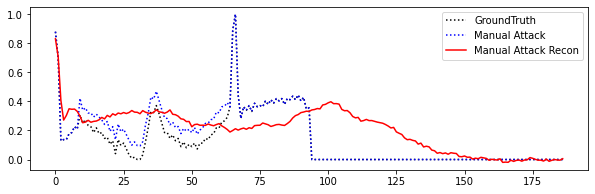

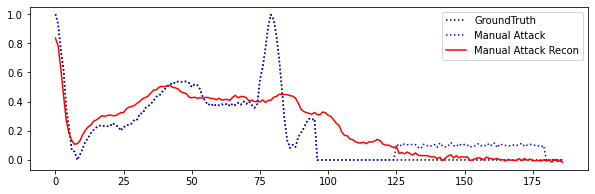

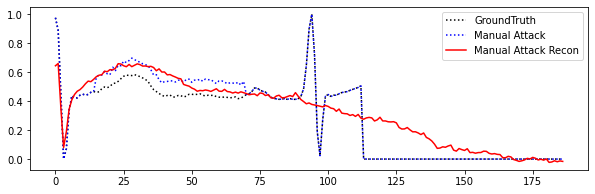

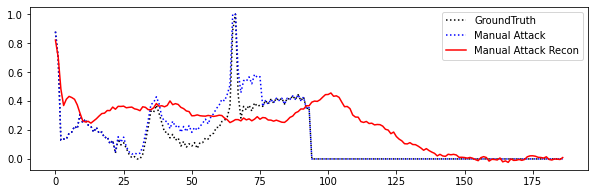

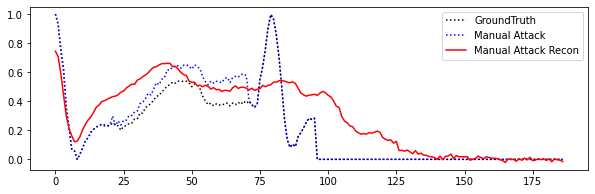

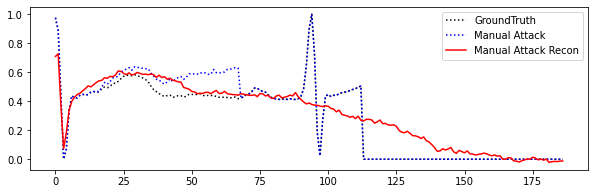

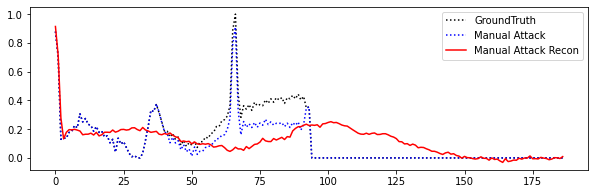

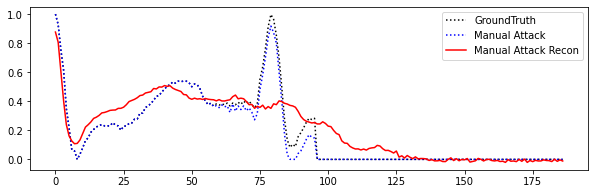

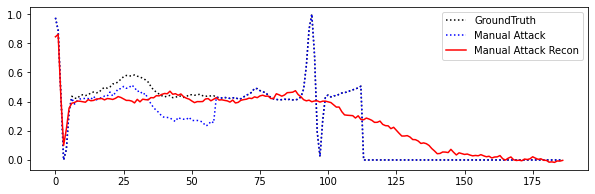

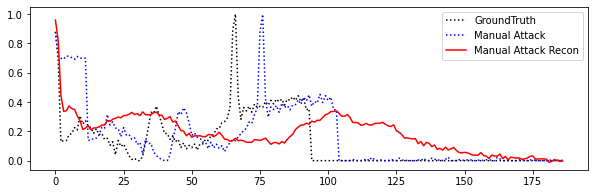

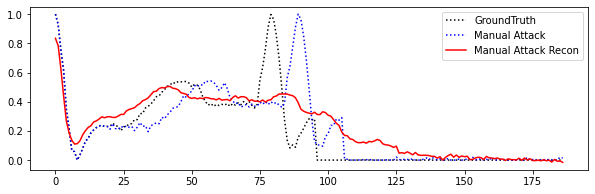

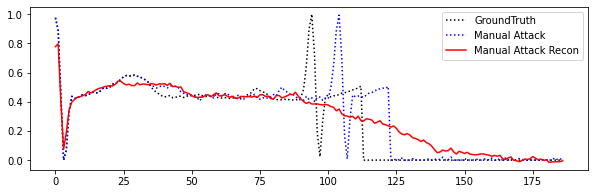

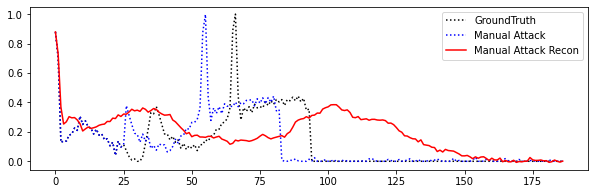

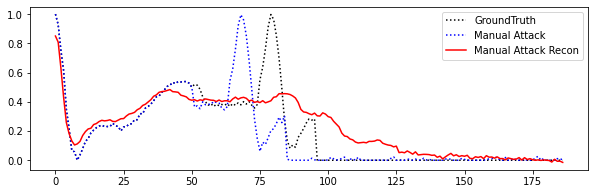

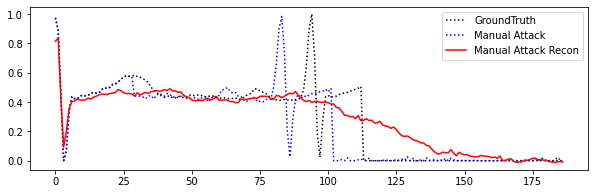

In [32]:
for attack in ['offset', 'increasing', 'decreasing', 'backward', 'forward']:
    if attack == 'offset':
        attack_loader = offset_test_loader 
    if attack == 'increasing':
        attack_loader = increasing_test_loader 
    if attack == 'decreasing':
        attack_loader = decreasing_test_loader 
    if attack == 'backward':
        attack_loader = backward_test_loader 
    if attack == 'forward':
        attack_loader = forward_test_loader 
        
    answers, predictions = attack_inference(model,attack_loader, attack)
    print(attack, np_mse(result_ans.values, predictions))
    result_ans_attack = pd.DataFrame(answers)
    result_ans_attack.to_csv(result_folder + f'cnndr_{attack}_reconstruction.csv')
    result_pred_attack = pd.DataFrame(predictions)
    result_pred_attack.to_csv(attack_result_folder + f'cnndr_{attack}_reconstruction_pred.csv')
    
    for i in range(3):
        plt.figure(figsize=(10,3))
        plt.plot(result_ans.iloc[i, :], c='black', ls=':', label = 'GroundTruth')
        plt.plot(result_ans_attack.iloc[i, :], c='blue', ls=':', label='Manual Attack')
        plt.plot(result_pred_attack.iloc[i, :], c='red', label='Manual Attack Recon')
        plt.legend()
        plt.savefig(result_folder + f'{attack}_sample{i}_reconresult.png')

## Balck Box Attack - fgsm

In [35]:
fgsm_attack = pd.read_csv(data_folder +'ECG_adv-eps-0.01-test.csv')
fgsm_attack = fgsm_attack.loc[df_test.index]
len(fgsm_attack)

10946

In [36]:
fgsm_test_dataset = MyDataset(fgsm_attack.values)
fgsm_test_loader = torch.utils.data.DataLoader(fgsm_test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

fgsm 0.014120002


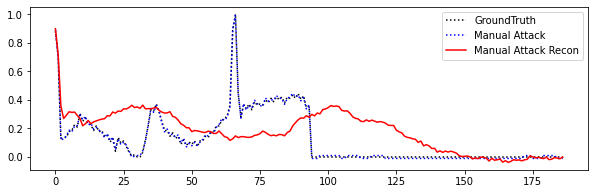

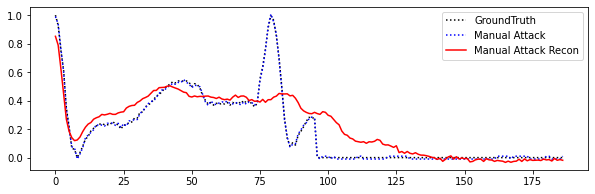

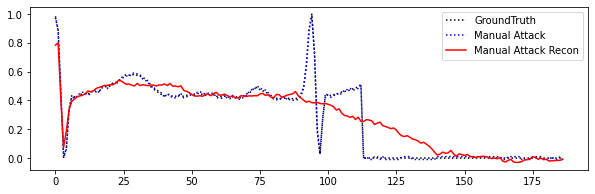

In [37]:
attack = 'fgsm'
answers, predictions = attack_inference(model,fgsm_test_loader, attack)
print(attack, np_mse(result_ans.values, predictions))
result_ans_attack = pd.DataFrame(answers)
result_ans_attack.to_csv(result_folder + f'cnndr_{attack}_reconstruction.csv')
result_pred_attack = pd.DataFrame(predictions)
result_pred_attack.to_csv(attack_result_folder + f'cnndr_{attack}_reconstruction_pred.csv')
    
for i in range(3):
    plt.figure(figsize=(10,3))
    plt.plot(result_ans.iloc[i, :], c='black', ls=':', label = 'GroundTruth')
    plt.plot(result_ans_attack.iloc[i, :], c='blue', ls=':', label='Manual Attack')
    plt.plot(result_pred_attack.iloc[i, :], c='red', label='Manual Attack Recon')
    plt.legend()
    plt.savefig(result_folder + f'{attack}_sample{i}_reconresult.png')